In [1]:
# MTREND

In [28]:
import datetime as dt

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

In [29]:
pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

In [30]:
import sys

sys.path.append("..")
from tooling.enums import AssetClass, Index, Spot, StrikeSpread
from tooling.fetch import fetch_option_data, fetch_spot_data
from tooling.filter import find_atm, option_tool

In [31]:
def get_expiry(f_today):
    days_to_thursday = (3 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


def get_option_contract_name(symbol, strike, expiry, opt_type):
    temp = "0"
    mth = expiry.month

    if (expiry + dt.timedelta(days=7)).month != expiry.month:
        date_string = expiry.strftime("%y%b").upper()
        return f"{symbol}{date_string}{strike}{opt_type}"
    else:
        if expiry.day <= 9:
            date_string = f"{expiry.year - 2000}{mth}{temp}{expiry.day}"
        else:
            date_string = f"{expiry.year - 2000}{mth}{expiry.day}"
        return f"{symbol}{date_string}{strike}{opt_type}"

In [61]:
bnf_pandas = pd.read_csv("../data/nifty_min (2).csv")

# INDEX = 'MIDCP'
# INDEX = 'BNF'
INDEX = 'NIFTY'
# INDEX = 'FNF'
# INDEX = 'STOCK'
# INDEX = 'SENSEX'

# lev_ = 1
INDEX_ = INDEX

if INDEX == 'BNF':
    lev_ = 6
    # lev_ = 4
    slippage_ = 0.0001
    lot_size_ = 30
    sma_ = 48
    tma_ = 18
    candles_ = 1
elif INDEX == 'NIFTY':
    lev_ = 7.5
    # lev_ = 5
    slippage_ = 0.0002
    lot_size_ = 75
    sma_ = 32
    tma_ = 40
    candles_ = 1
elif INDEX == 'MIDCP':
    lev_ = 4.5
    # lev_ = 5
    slippage_ = 0.0005
    lot_size_ = 120
    sma_ = 9
    tma_ = 68
    candles_ = 1
elif INDEX == 'SENSEX':
    lev_ = 7.5
    # lev_ = 5
    slippage_ = 0.0001
    lot_size_ = 20
    sma_ = 45
    tma_ = 16
    candles_ = 1
elif INDEX == 'STOCK':
    lev_ = 5
    slippage_ = 0.001
    lot_size_ = 1
# bnf_pandas = pd.read_csv("../data/finnifty_1hr_tv (2).csv")
# bnf_pandas = pd.read_csv('../data/midcp_1hr_tv (4).csv')
# bnf_pandas = pd.read_csv('../data/finnifty_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/bnf_fut_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/gold_4hr_tv.csv')


In [62]:
bnf_pandas['datetime'] = pd.to_datetime(bnf_pandas['datetime'])
bnf_pandas = bnf_pandas[bnf_pandas['datetime'].dt.time <= dt.time(15, 29)]
bnf_pandas.tail()

,index,datetime,open,high,low,close,volume
777613,nifty,2025-05-30 15:25:00,24741.4000,24742.7000,24740.5000,24741.7000,0
777614,nifty,2025-05-30 15:26:00,24742.2500,24746.2000,24740.3000,24740.3000,0
777615,nifty,2025-05-30 15:27:00,24741.0500,24749.0500,24739.5000,24747.1500,0
777616,nifty,2025-05-30 15:28:00,24746.5500,24746.8000,24731.1000,24745.2500,0
777617,nifty,2025-05-30 15:29:00,24743.6000,24749.3000,24731.8500,24736.6500,0


In [63]:
def parse_timeframe(timeframe: str) -> pl.duration:
    if timeframe.endswith('m'):
        return pl.duration(minutes=int(timeframe[:-1]))
    elif timeframe.endswith('h'):
        return pl.duration(hours=int(timeframe[:-1]))
    # Add more cases if needed
    else:
        raise ValueError(f"Unknown timeframe format: {timeframe}")

def resample(data: pl.DataFrame, timeframe: str, offset: str = '0m') -> pl.DataFrame:
    # data = data.with_columns(
    #     pl.col("datetime").str.strptime(pl.Datetime, strict=False)   # <-- fix here
    # )
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(
            [
                pl.col("open").first().alias("open"),
                pl.col("high").max().alias("high"),
                pl.col("low").min().alias("low"),
                pl.col("close").last().alias("close"),
                pl.col("volume").sum().alias("volume"),
            ]
        )
    )


In [64]:
bnf = pl.DataFrame(bnf_pandas)
bnf_1hr = resample(bnf, '60m', '15m')   # offset can be '0m' if you want no offset
bnf = bnf_1hr

In [65]:
bnf.tail(100)

datetime,open,high,low,close,volume
datetime[ns],f64,f64,f64,f64,i64
2025-05-12 14:15:00,24866.25,24930.4,24854.75,24907.45,0
2025-05-12 15:15:00,24907.45,24944.8,24904.75,24920.25,0
2025-05-13 09:15:00,24864.05,24973.8,24675.6,24770.85,0
2025-05-13 10:15:00,24771.1,24837.8,24634.9,24724.55,0
2025-05-13 11:15:00,24725.05,24817.9,24693.9,24755.45,0
2025-05-13 12:15:00,24755.55,24772.0,24597.6,24630.8,0
2025-05-13 13:15:00,24633.4,24637.0,24576.0,24590.45,0
2025-05-13 14:15:00,24590.25,24636.85,24559.15,24560.0,0
2025-05-13 15:15:00,24561.05,24594.3,24547.5,24593.65,0


In [66]:
def generate_signals1(df, signal_ma, trailing_ma, candles_in_num):
    df["c"] = pd.to_numeric(df["c"], errors="coerce")
    df["MA20"] = df["c"].rolling(window=signal_ma).mean()
    df["MA10"] = df["c"].rolling(window=trailing_ma).mean()

    df["Buy_Signal"] = 0

    # Generate signals using boolean masking
    buy_signal_mask = df["MA20"] > df["MA20"].shift(1)
    
    for i in range(1, candles_in_num):
        buy_signal_mask &= df["MA20"].shift(i) > df["MA20"].shift(i + 1)

    df.loc[buy_signal_mask, "Buy_Signal"] = 1

    return df

In [67]:
def generate_signals2(df, i, j, candles_in_num):
    df["c"] = pd.to_numeric(df["c"], errors="coerce")
    df["MA20"] = df["c"].rolling(window=i).mean()
    df["MA10"] = df["c"].rolling(window=j).mean()

    df["Sell_Signal"] = 0

    # Generate signals using boolean masking
    sell_signal_mask = df["MA20"] < df["MA20"].shift(1)

    for i in range(1, candles_in_num):
        sell_signal_mask &= df["MA20"].shift(i) < df["MA20"].shift(i + 1)

    df.loc[sell_signal_mask, "Sell_Signal"] = 1

    return df

In [68]:
# Positional

def execute(df):

    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    is_trailing_active = False
    remark = ""
    portfolio_value = 6250000
    previous_trade_exit_time = None

    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_candle_datetime = df.iloc[i]['datetime']
        current_moving_average_price = df.iloc[i]["MA10"]

        if current_candle_datetime.time() == dt.time(15, 15):
            df.iloc[i]['Buy_Signal'] = 0
            # continue
        if not in_trade:
            if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
                if df.iloc[i-1]['Buy_Signal'] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
                    signal_entry_price = df.iloc[i-1]['h']
                    signal_initial_sl = df.iloc[i-1]['l']
                    signal_creation_time = df.iloc[i-1]['datetime']
                    if current_candle_high >= signal_entry_price:
                        #Entry Triggered
                        entry_price = signal_entry_price
                        entry_time = current_candle_datetime
                        in_trade = True

        # if not in_trade:
        #     if current_candle_datetime.time() == dt.time(15, 15):
        #         df.iloc[i]["Buy_Signal"] = 0
        #         continue
        #     if df.iloc[i]["Buy_Signal"] == 1 and current_candle_datetime.time() < dt.time(15, 15):
        #         if not already_signal_exists:
        #             # Fresh Buy Signal
        #             # print(df.iloc[i])
        #             # print('Fresh Buy Signal')
        #             signal_entry_price = current_candle_high
        #             signal_initial_sl = current_candle_low
        #             signal_creation_time = df.iloc[i]["datetime"]
        #             already_signal_exists = True

        #             # if (signal_entry_price - signal_initial_sl > 400):
        #             #     # Skip Signal Candle Due To Big Size
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0

        #         else:
        #             # if current_candle_open > signal_entry_price:
        #             #     # Gap Up Open, SKIP trade
        #             #     # print(df.iloc[i])
        #             #     # print('Gap Up Open, Skip Trade')
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0
                    
        #             if current_candle_high < signal_entry_price:
        #                 # Better Candle
        #                 # print(df.iloc[i])
        #                 # print('Better Candle')
        #                 signal_entry_price = current_candle_high
        #                 signal_initial_sl = current_candle_low
        #                 signal_creation_time = df.iloc[i]["datetime"]

        #                 # if (signal_entry_price - signal_initial_sl > 400):
        #                 #     # Skip Signal Candle Due To Big Size
        #                 #     already_signal_exists = False
        #                 #     signal_entry_price = 100000
        #                 #     signal_initial_sl = 0

        #             elif current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
        #                 # Entry Triggered
        #                 # print(df.iloc[i])
        #                 # print('Entry Triggered')
        #                 in_trade = True
        #                 entry_time = df.iloc[i]["datetime"]
        #                 entry_price = signal_entry_price
        #                 points = 0
        #     else:
        #         if df.iloc[i - 1]["Buy_Signal"] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
        #             # Considering the forward bias condition as well now
        #             signal_entry_price = df.iloc[i - 1]["h"]
        #             signal_initial_sl = df.iloc[i - 1]["l"]
        #             signal_creation_time = df.iloc[i - 1]["datetime"]
        #             already_signal_exists = True

        #             # if current_candle_open > signal_entry_price:
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0

        #             if current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
        #                 if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
        #                     in_trade = True
        #                     entry_time = df.iloc[i]["datetime"]
        #                     entry_price = signal_entry_price
        #                     points = 0
        #             else:
        #                 # Discard Existing Signal
        #                 already_signal_exists = False
        #                 signal_entry_price = 100000
        #                signal_initial_sl = 0

            # if df.iloc[i-1]["Buy_Signal"] == 1:
            #     signal_entry_price = df.iloc[i-1]['h']
            #     signal_initial_sl = df.iloc[i-1]['l']
            #     signal_creation_time = df.iloc[i-1]["datetime"]

            #     if current_candle_open > signal_entry_price:
            #         # Gap Up Open, SKIP trade
            #         already_signal_exists = False
            #         signal_entry_price = 100000
            #         signal_initial_sl = 0
                
            #     elif current_candle_high >= signal_entry_price:
            #         # Entry Triggered
            #         in_trade = True
            #         entry_time = df.iloc[i]["datetime"]
            #         entry_price = signal_entry_price
            #         points = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_low > current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open < trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit Before Gap Down'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # Initial SL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

            else:
                trade_final_sl = max(trade_initial_sl, current_moving_average_price)

                if current_candle_open <= trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # if trade_initial_sl >= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close <= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = current_candle_close - trade_entry_price
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                index_lev = lev_
                qty = int(round(portfolio_value * index_lev / entry_price / lot_size_)) * lot_size_
                slippage = slippage_ * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points
                previous_trade_exit_time = exit_time
                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "LONG",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": index_lev,
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False
                i += 1

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [69]:
# # Positional

# def execute(df):

#     trade_book = []
#     in_trade = False
#     signal_entry_price = 100000
#     signal_initial_sl = 0
#     already_signal_exists = False
#     is_trailing_active = False
#     remark = ""
#     portfolio_value = 6250000
#     previous_trade_exit_time = None

#     for i in range(1, len(df)):
#         points = 0
#         current_candle_open = df.iloc[i]["o"]
#         current_candle_high = df.iloc[i]["h"]
#         current_candle_low = df.iloc[i]["l"]
#         current_candle_close = df.iloc[i]["c"]
#         current_candle_datetime = df.iloc[i]['datetime']
#         current_moving_average_price = df.iloc[i]["MA10"]

#         if not in_trade:
#             if df.iloc[i-1]['datetime'] != previous_
#             if df.iloc[i]["Buy_Signal"] == 1 and current_candle_datetime.time() < dt.time(15, 15):
#                 if not already_signal_exists:
#                     # Fresh Buy Signal
#                     # print(df.iloc[i])
#                     # print('Fresh Buy Signal')
#                     signal_entry_price = current_candle_high
#                     signal_initial_sl = current_candle_low
#                     signal_creation_time = df.iloc[i]["datetime"]
#                     already_signal_exists = True

#                     # if (signal_entry_price - signal_initial_sl > 400):
#                     #     # Skip Signal Candle Due To Big Size
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0

#                 else:
#                     # if current_candle_open > signal_entry_price:
#                     #     # Gap Up Open, SKIP trade
#                     #     # print(df.iloc[i])
#                     #     # print('Gap Up Open, Skip Trade')
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0
                    
#                     if current_candle_high < signal_entry_price:
#                         # Better Candle
#                         # print(df.iloc[i])
#                         # print('Better Candle')
#                         signal_entry_price = current_candle_high
#                         signal_initial_sl = current_candle_low
#                         signal_creation_time = df.iloc[i]["datetime"]

#                         # if (signal_entry_price - signal_initial_sl > 400):
#                         #     # Skip Signal Candle Due To Big Size
#                         #     already_signal_exists = False
#                         #     signal_entry_price = 100000
#                         #     signal_initial_sl = 0

#                     elif current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
#                         # Entry Triggered
#                         # print(df.iloc[i])
#                         # print('Entry Triggered')
#                         in_trade = True
#                         entry_time = df.iloc[i]["datetime"]
#                         entry_price = signal_entry_price
#                         points = 0
#             else:
#                 if df.iloc[i - 1]["Buy_Signal"] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
#                     # Considering the forward bias condition as well now
#                     signal_entry_price = df.iloc[i - 1]["h"]
#                     signal_initial_sl = df.iloc[i - 1]["l"]
#                     signal_creation_time = df.iloc[i - 1]["datetime"]
#                     already_signal_exists = True

#                     # if current_candle_open > signal_entry_price:
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0

#                     if current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
#                         if df.iloc[i-1]['datetime'] > previous_trade_exit_time:
#                             in_trade = True
#                             entry_time = df.iloc[i]["datetime"]
#                             entry_price = signal_entry_price
#                             points = 0
#                         else:
#                             df.iloc[i-1]['Buy_Signal'] = 0
#                     else:
#                         # Discard Existing Signal
#                         already_signal_exists = False
#                         signal_entry_price = 100000
#                         signal_initial_sl = 0

#             # if df.iloc[i-1]["Buy_Signal"] == 1:
#             #     signal_entry_price = df.iloc[i-1]['h']
#             #     signal_initial_sl = df.iloc[i-1]['l']
#             #     signal_creation_time = df.iloc[i-1]["datetime"]

#             #     if current_candle_open > signal_entry_price:
#             #         # Gap Up Open, SKIP trade
#             #         already_signal_exists = False
#             #         signal_entry_price = 100000
#             #         signal_initial_sl = 0
                
#             #     elif current_candle_high >= signal_entry_price:
#             #         # Entry Triggered
#             #         in_trade = True
#             #         entry_time = df.iloc[i]["datetime"]
#             #         entry_price = signal_entry_price
#             #         points = 0

#         if in_trade:
#             trade_entry_price = signal_entry_price
#             trade_initial_sl = signal_initial_sl
#             trade_final_sl = signal_initial_sl

#             if (
#                 not is_trailing_active
#                 and current_candle_low > current_moving_average_price
#             ):
#                 is_trailing_active = True

#             if not is_trailing_active:
#                 if current_candle_open < trade_initial_sl:
#                     # if df.iloc[i-1]['l'] < trade_initial_sl:
#                     #     #Previous Candle Already Hit the SL Hence don't check gap down
#                     #     print(df.iloc[i])
#                     #     print('Initial SL Hit Before Gap Down')
#                     #     in_trade = False
#                     #     points = trade_initial_sl - trade_entry_price
#                     #     exit_price = trade_initial_sl
#                     #     exit_time = df.iloc[i-1]['datetime']
#                     #     remark = 'Initial SL Hit Before Gap Down'
#                     # else:
#                     if (
#                         df.iloc[i]["datetime"].date() == entry_time.date()
#                         and df.iloc[i]["datetime"].time() == entry_time.time()
#                     ):
#                         if current_candle_close <= trade_initial_sl:
#                             in_trade = False
#                             points = trade_initial_sl - trade_entry_price
#                             exit_price = trade_initial_sl
#                             exit_time = df.iloc[i]["datetime"]
#                             remark = "Initial SL hit"

#                     else:
#                         # Gap Open Outside ISL
#                         # print(df.iloc[i])
#                         # print('Gap Open Outside ISL')
#                         in_trade = False
#                         points = current_candle_open - trade_entry_price
#                         exit_price = current_candle_open
#                         exit_time = df.iloc[i]["datetime"]
#                         remark = "Gap Open Outside ISL"

#                 elif current_candle_low <= trade_initial_sl:
#                     # Initial SL Hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = trade_initial_sl - trade_entry_price
#                     exit_price = trade_initial_sl
#                     exit_time = df.iloc[i]["datetime"]
#                     remark = "Initial SL Hit"

#             else:
#                 trade_final_sl = max(trade_initial_sl, current_moving_average_price)

#                 if current_candle_open <= trade_initial_sl:
#                     # if df.iloc[i-1]['l'] < trade_initial_sl:
#                     #     #Previous Candle Already Hit the SL Hence don't check gap down
#                     #     print(df.iloc[i])
#                     #     print('Initial SL Hit Before Gap Down')
#                     #     in_trade = False
#                     #     points = trade_initial_sl - trade_entry_price
#                     #     exit_price = trade_initial_sl
#                     #     exit_time = df.iloc[i-1]['datetime']
#                     #     remark = 'Initial SL Hit'
#                     # else:
#                     if (
#                         df.iloc[i]["datetime"].date() == entry_time.date()
#                         and df.iloc[i]["datetime"].time() == entry_time.time()
#                     ):
#                         if current_candle_close <= trade_initial_sl:
#                             in_trade = False
#                             points = trade_initial_sl - trade_entry_price
#                             exit_price = trade_initial_sl
#                             exit_time = df.iloc[i]["datetime"]
#                             remark = "Initial SL hit"

#                     else:
#                         # Gap Open Outside ISL
#                         # print(df.iloc[i])
#                         # print('Gap Open Outside ISL')
#                         in_trade = False
#                         points = current_candle_open - trade_entry_price
#                         exit_price = current_candle_open
#                         exit_time = df.iloc[i]["datetime"]
#                         remark = "Gap Open Outside ISL"

#                 elif current_candle_low <= trade_initial_sl:
#                     # if trade_initial_sl >= current_moving_average_price:
#                     # Despite Trailing, Initial SL hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = trade_initial_sl - trade_entry_price
#                     exit_price = trade_initial_sl
#                     exit_time = df.iloc[i]["datetime"]
#                     remark = "Initial SL hit"

#                 elif current_candle_close <= trade_final_sl:
#                     # Price Closed below TSL i.e. MA10 , TSL Hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = current_candle_close - trade_entry_price
#                     exit_price = current_candle_close
#                     exit_time = df.iloc[i]["datetime"]
#                     is_trailing_active = False
#                     remark = "TSL Hit"

#             if points:
#                 index_lev = lev_
#                 qty = int(round(portfolio_value * index_lev / entry_price / lot_size_)) * lot_size_
#                 slippage = slippage_ * (entry_price + exit_price)
#                 # slippage = 10
#                 final_points = points - slippage
#                 # final_points = points
#                 previous_trade_exit_time = exit_time
#                 trade = {
#                     "Signal Generated At": signal_creation_time,
#                     "Trade Type": "LONG",
#                     "Entry Time": entry_time,
#                     "Entry Price": entry_price,
#                     "Initial SL": trade_initial_sl,
#                     "Final SL": trade_final_sl,
#                     "Exit Time": exit_time,
#                     "Exit Price": exit_price,
#                     "Points Captured": points,
#                     "After Costs": final_points,
#                     "PnL": final_points * qty,
#                     "Remarks": remark,
#                     "Qty": qty,
#                     "Leverage": index_lev,
#                     "ROI%": (final_points * qty / portfolio_value) * 100,
#                     "Trade Year": entry_time.year,
#                     "Trade Month": entry_time.month,
#                 }
#                 trade_book.append(trade)
#                 points = 0
#                 in_trade = False
#                 already_signal_exists = False
#                 remark = ""
#                 is_trailing_active = False
#                 # previous_exit_time = exit_time

#     trade_book_df = pd.DataFrame(trade_book)
#     return trade_book_df

In [70]:
bnf1 = bnf
bnf2 = bnf

In [71]:
def generate_stats(tb_expiry, signal_ma, trailing_ma):
    stats_df8 = pd.DataFrame(
        index=range(2017, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2017, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f'{signal_ma} , {trailing_ma}'
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation
    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio : stats_df8}

In [72]:
bnf1 = bnf1.to_pandas()
bnf2 = bnf2.to_pandas()

In [73]:
bnf1['datetime'] = pd.to_datetime(bnf1['datetime'])
bnf2['datetime'] = pd.to_datetime(bnf2['datetime'])

In [74]:
bnf1 = bnf1[bnf1['datetime'].dt.time >= dt.time(9, 14)]
bnf1 = bnf2[bnf2['datetime'].dt.time >= dt.time(9, 14)]

In [75]:
bnf1.tail(6600)

,datetime,open,high,low,close,volume
7918,2021-08-04 09:15:00,16195.2500,16263.5000,16188.5500,16251.7500,0
7919,2021-08-04 10:15:00,16251.8000,16290.0000,16250.5000,16271.9000,0
7920,2021-08-04 11:15:00,16271.5000,16271.6000,16204.7000,16257.9500,0
7921,2021-08-04 12:15:00,16257.4000,16266.8000,16219.4500,16236.4000,0
7922,2021-08-04 13:15:00,16236.2500,16271.0000,16236.2500,16265.2500,0
7923,2021-08-04 14:15:00,16266.6000,16285.0500,16247.2500,16265.7000,0
7924,2021-08-04 15:15:00,16265.2000,16266.7500,16245.6000,16253.0000,0
7925,2021-08-05 09:15:00,16288.9500,16293.3000,16211.2000,16239.1000,0
7926,2021-08-05 10:15:00,16240.3500,16251.5000,16221.1000,16239.3000,0
7927,2021-08-05 11:15:00,16239.0000,16280.1000,16237.4000,16279.2500,0


In [76]:
# stats_dictionary = {}

# for i in range(6, 81):
#     for j in range(4, 101, 2):
#         print(f"Signal MA : {i} , Trailing MA : {j}")
#         signals_df1 = generate_signals1(bnf1, i, j)
#         signals_df1 = signals_df1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})
#         new_tb = execute(signals_df1)
#         new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
#         tradebook_buy_side = new_tb
#         stats = generate_stats(tradebook_buy_side, i, j)
#         for overall_roi_dd_ratio, stats_df in stats.items():
#             if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 10:
#                 print(stats_df.to_string())
#                 stats_dictionary[overall_roi_dd_ratio] = stats_df

In [77]:
# sorted_stats = {k: v for k, v in sorted(stats_dictionary.items(), key=lambda item: item[0], reverse=True)}
# sorted_stats

In [78]:
bnf1 = bnf1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})

In [79]:
sma = 33
tma = 16
candles = 1
variation = f'{INDEX}, {sma} , {tma} , {candles}'
signals_df1 = generate_signals1(bnf1, sma, tma, candles)

In [80]:
# signals_df2.tail(130)

In [81]:

new_tb = execute(signals_df1)
# new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
tradebook_buy_side = new_tb
# new_tb

/tmp/ipykernel_20908/3328190458.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i]['Buy_Signal'] = 0


In [82]:
# tradebook_buy_side['DD%'] = (tradebook_buy_side['ROI%'].cumsum() - tradebook_buy_side['ROI%'].cumsum().cummax())
# tradebook_buy_side

In [83]:
# new_tb.tail(50)
new_tb[new_tb['Entry Time'].dt.time == dt.time(9, 15)]

,Signal Generated At,Trade Type,Entry Time,Entry Price,Initial SL,Final SL,Exit Time,Exit Price,Points Captured,After Costs,PnL,Remarks,Qty,Leverage,ROI%,Trade Year,Trade Month


In [56]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2017, 2026),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2017, 2026):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = variation
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    
    # print(f'{overall_total_roi} , {overall_max_drawdown} , {overall_roi_dd_ratio}')
    
    return {overall_roi_dd_ratio: stats_df8}

In [57]:
final_stats = None
stats = generate_stats(tradebook_buy_side, variation)
for x, y in stats.items():
    final_stats = y

final_stats

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2017,40.1035,105,29.5238,5.7706,-1.8755,-27.8614,1.4394,"NIFTY, 33 , 16 , 1"
2018,82.6993,80,40.0000,5.9393,-2.2366,-25.1875,3.2833,"NIFTY, 33 , 16 , 1"
2019,74.5345,75,33.3333,8.3260,-2.6723,-28.7335,2.5940,"NIFTY, 33 , 16 , 1"
2020,171.3919,82,34.1463,12.7425,-3.4333,-35.2489,4.8623,"NIFTY, 33 , 16 , 1"
2021,111.9471,87,35.6322,8.5464,-2.7320,-19.0030,5.8910,"NIFTY, 33 , 16 , 1"
2022,76.7545,72,36.1111,9.3149,-3.5964,-41.8285,1.8350,"NIFTY, 33 , 16 , 1"
2023,140.1493,81,39.5062,7.7550,-2.2043,-22.6846,6.1782,"NIFTY, 33 , 16 , 1"
2024,75.4088,81,33.3333,8.1113,-2.6592,-19.5074,3.8657,"NIFTY, 33 , 16 , 1"
2025,6.5526,36,25.0000,10.2974,-3.1898,-23.1156,0.2835,"NIFTY, 33 , 16 , 1"
Overall,779.5414,699,34.4778,8.3023,-2.6666,-41.8285,18.6366,"NIFTY, 33 , 16 , 1"


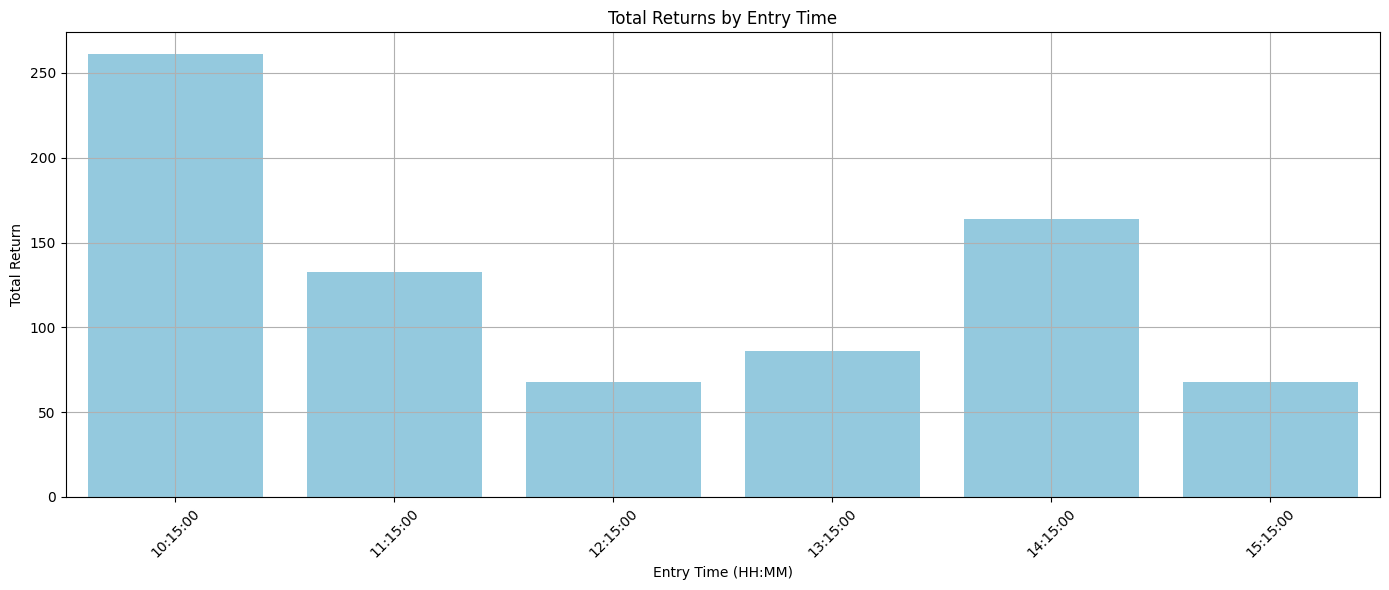

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = tradebook_buy_side.copy()  # your DataFrame

# Step 1: Convert time to string format (HH:MM) for better x-axis display
df['entry_time_str'] = df['Entry Time'].dt.time.apply(lambda t: t.strftime('%H:%M:%S'))

# Step 2: Group by time and sum the returns
agg_df = df.groupby('entry_time_str')['ROI%'].sum().reset_index()

# Step 3: Plot the summed returns by time
plt.figure(figsize=(14, 6))
sns.barplot(x='entry_time_str', y='ROI%', data=agg_df, color='skyblue')
plt.xticks(rotation=45)
plt.title('Total Returns by Entry Time')
plt.xlabel('Entry Time (HH:MM)')
plt.ylabel('Total Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
final_stats = None
stats = generate_stats(tradebook_buy_side, variation)
for x, y in stats.items():
    final_stats = y

final_stats

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2017,40.1035,105,29.5238,5.7706,-1.8755,-27.8614,1.4394,"NIFTY, 33 , 16 , 1"
2018,82.6993,80,40.0000,5.9393,-2.2366,-25.1875,3.2833,"NIFTY, 33 , 16 , 1"
2019,74.5345,75,33.3333,8.3260,-2.6723,-28.7335,2.5940,"NIFTY, 33 , 16 , 1"
2020,171.3919,82,34.1463,12.7425,-3.4333,-35.2489,4.8623,"NIFTY, 33 , 16 , 1"
2021,111.9471,87,35.6322,8.5464,-2.7320,-19.0030,5.8910,"NIFTY, 33 , 16 , 1"
2022,76.7545,72,36.1111,9.3149,-3.5964,-41.8285,1.8350,"NIFTY, 33 , 16 , 1"
2023,140.1493,81,39.5062,7.7550,-2.2043,-22.6846,6.1782,"NIFTY, 33 , 16 , 1"
2024,75.4088,81,33.3333,8.1113,-2.6592,-19.5074,3.8657,"NIFTY, 33 , 16 , 1"
2025,6.5526,36,25.0000,10.2974,-3.1898,-23.1156,0.2835,"NIFTY, 33 , 16 , 1"
Overall,779.5414,699,34.4778,8.3023,-2.6666,-41.8285,18.6366,"NIFTY, 33 , 16 , 1"


In [60]:
tradebook_buy_side.to_csv(f'{INDEX_}_mtrend.csv', index=False)

In [57]:
# bnf1 = bnf1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})

In [28]:
stats_dict = {}

for i in range(26, 35):
    for j in range(14, 17):
            variation = f'SMA: {i}, TMA: {j}'
            print(variation)
            signals_df1 = generate_signals1(bnf1, i, j, 1)
            new_tb = execute(signals_df1)
            stats = generate_stats(new_tb, variation)
            for overall_roi_dd_ratio, stats_df in stats.items():
                if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 15:
                    stats_dict[overall_roi_dd_ratio] = stats_df
                    print(stats_df.to_string())

SMA: 26, TMA: 14
SMA: 26, TMA: 15
SMA: 26, TMA: 16
SMA: 27, TMA: 14
SMA: 27, TMA: 15
SMA: 27, TMA: 16
SMA: 28, TMA: 14
SMA: 28, TMA: 15
SMA: 28, TMA: 16
SMA: 29, TMA: 14
SMA: 29, TMA: 15
SMA: 29, TMA: 16
SMA: 30, TMA: 14
SMA: 30, TMA: 15
SMA: 30, TMA: 16
        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio         Variation
2019      51.9502           74  32.4324                7.2907             -2.4605     -25.2677       2.0560  SMA: 30, TMA: 16
2020     237.2684           85  35.2941               13.7379             -3.1794     -43.1370       5.5003  SMA: 30, TMA: 16
2021     112.8034           89  32.5843                9.3158             -2.6226     -23.5503       4.7899  SMA: 30, TMA: 16
2022      60.9325           70  35.7143                9.1138             -3.7091     -45.3586       1.3433  SMA: 30, TMA: 16
2023     125.6552           84  33.3333                8.4879             -2.0001     -16.1621       7.7747  SMA: 3

In [29]:
sorted_stats = {k: v for k, v in sorted(stats_dict.items(), key=lambda item: item[0], reverse=True)}

In [30]:
sorted_stats

{18.277232772182995:         Total ROI Total Trades Win Rate Avg Profit% per Trade  \
 2019      62.2957           74  33.7838                7.3997   
 2020     178.9443           81  34.5679               12.7425   
 2021     142.6161           84  38.0952                8.9339   
 2022      87.1175           70  38.5714                8.9485   
 2023     134.4474           82  36.5854                8.1994   
 2024      75.0085           81  33.3333                8.1113   
 2025      12.6742           16  31.2500               10.4326   
 Overall  693.1037          488  34.6726                8.3600   
 
         Avg Loss% per Trade Max Drawdown ROI/DD Ratio         Variation  
 2019                -2.5040     -25.8186       2.4128  SMA: 33, TMA: 16  
 2020                -3.3556     -29.9979       5.9652  SMA: 33, TMA: 16  
 2021                -2.7552     -22.9175       6.2230  SMA: 33, TMA: 16  
 2022                -3.5928     -34.1094       2.5541  SMA: 33, TMA: 16  
 2023    

# MTrend BNF

In [36]:
# new_tb.to_csv('BNF Mtrend New.csv', index=False)

In [139]:
# Positional Sell Side


def execute_sell_side(df):
    portfolio_value = 7500000
    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    remark = ""
    is_trailing_active = False
    previous_trade_exit_time = None

    print(lev_, slippage_, portfolio_value)
    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_moving_average_price = df.iloc[i]["MA10"]

        if not in_trade:
            if df.iloc[i]["Sell_Signal"] == 1:
                if not already_signal_exists:
                    # Fresh Sell Signal
                    # print(df.iloc[i])
                    # print('Fresh Short Sell Signal')
                    signal_entry_price = current_candle_low
                    signal_initial_sl = current_candle_high
                    signal_creation_time = df.iloc[i]["datetime"]
                    already_signal_exists = True

                    # if (signal_initial_sl - signal_entry_price > 400):
                    #     # Skip Signal Candle Due To Big Size
                    #     already_signal_exists = False
                    #     signal_entry_price = 100000
                    #     signal_initial_sl = 0

                else:
                    if current_candle_open < signal_entry_price:
                        # Gap Down Outside, SKIP trade
                        # print('Signal Entry Price' , signal_entry_price)
                        # print(df.iloc[i])
                        # print('Gap Outside, Skip Trade')
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0
                    elif current_candle_low > signal_entry_price:
                        # Better Candle
                        
                        # print(df.iloc[i])
                        # print('Better Candle')
                        signal_entry_price = current_candle_low
                        signal_initial_sl = current_candle_high
                        signal_creation_time = df.iloc[i]["datetime"]

                        # if (signal_initial_sl - signal_entry_price > 400):
                        #     # Skip Signal Candle Due To Big Size
                        #     already_signal_exists = False
                        #     signal_entry_price = 100000
                        #     signal_initial_sl = 0

                    elif current_candle_low < signal_entry_price:
                        # Entry Triggered
                        
                        # print(df.iloc[i])
                        # print('Entry Triggered')
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
            else:
                if df.iloc[i - 1]["Sell_Signal"] == 1:
                    # Considering the forward bias condition as well now
                    signal_entry_price = df.iloc[i - 1]["l"]
                    signal_initial_sl = df.iloc[i - 1]["h"]
                    signal_creation_time = df.iloc[i - 1]["datetime"]
                    already_signal_exists = True

                    if current_candle_low < signal_entry_price:
                        if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
                            in_trade = True
                            entry_time = df.iloc[i]["datetime"]
                            entry_price = signal_entry_price
                            points = 0
                    else:
                        # Discard Existing Signal
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_high < current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        
                        # print(df.iloc[i])
                        # print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # Initial SL Hit
                    
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

                elif current_candle_close >= trade_final_sl:
                    # TSL Hit
                    # print(df.iloc[i])
                    # print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    remark = "TSL Hit"

            elif is_trailing_active:
                trade_final_sl = min(trade_initial_sl, current_moving_average_price)

                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        
                        # print(df.iloc[i])
                        # print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # if trade_initial_sl <= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close >= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                qty = int(round((portfolio_value * lev_ / entry_price) / lot_size_) * lot_size_)
                slippage = slippage_ * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points
                previous_trade_exit_time = exit_time
                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "SHORT",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": lev_,
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                # print(trade)
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [38]:
# bnf_pandas = pd.read_csv('../data/midcp_1hr_tv_new.csv')

In [39]:
# bnf_pandas.head()

In [40]:
# # If Stocks Data ...
# bnf_pandas["datetime"] = pd.to_datetime(bnf_pandas["time"])
# bnf_pandas["datetime"] = bnf_pandas["datetime"].dt.tz_localize(None)
# bnf_pandas = bnf_pandas[bnf_pandas["datetime"].dt.year >= 2017]
# bnf_pandas.drop(columns=["time"], inplace=True)
# # bnf_pandas

In [41]:
# bnf = pl.DataFrame(bnf_pandas)
# bnf = bnf.with_columns([pl.col("datetime").alias("index")]).drop("datetime")


In [42]:
# data = pl.DataFrame(data)
# data = data.with_columns([
#     pl.col("datetime").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
# ])

In [140]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2022, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2022, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = variation
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation
    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio : stats_df8}

In [44]:
# targets = [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 100]
# time_frames = ["3m", "5m", "10m", "15m", "30m", "60m"]
# num_candles = [1, 2, 3, 4, 5]
# for i in range(5, 81, 5):
#     for j in range(5, 81, 5):
#         for k in targets:
#             for tf in time_frames:
#                 for candles in num_candles:
#                     if tf == "10m":
#                         offset = "5m"
#                     elif tf == "30m" or tf == "60m":
#                         offset = "15m"
#                     else:
#                         offset = "0m"
#                     variation = f"SMA: {i}, TMA: {j}, Target: {k}R, TF: {tf}, Candles: {candles}"
#                     print(variation)
#                     data_w_signals = (resample(data, tf, offset)).to_pandas()
#                     data_w_signals = generate_signals2(data_w_signals, i, j, candles)
#                     data_w_signals2 = data_w_signals.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})
#                     sell_tb = execute_sell_side(data_w_signals2)
#                     stats = generate_stats(sell_tb, variation)
#                     for overall_roi_dd_ratio, stats_df in stats.items():
#                         if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 3:
#                             print(stats_df.to_string())
#                             stats_dictionary[overall_roi_dd_ratio] = stats_df

In [ ]:
# tradebook_sell_side

In [45]:
# bnf_pandas.head()

In [180]:
signals_df1 = generate_signals2(bnf1, 50, 49, 5)
tradebook_sell_side = execute_sell_side(signals_df1)

3 0.0005 7500000


In [182]:
# tradebook_sell_side = tradebook_sell_side[154:]
tradebook_sell_side

,Signal Generated At,Trade Type,Entry Time,Entry Price,Initial SL,Final SL,Exit Time,Exit Price,Points Captured,After Costs,PnL,Remarks,Qty,Leverage,ROI%,Trade Year,Trade Month
0,2022-01-21 10:15:00,SHORT,2022-01-21 11:15:00,7616.7500,7690.5500,7544.0520,2022-01-28 10:15:00,7549.4500,67.3000,59.7169,176164.8550,TSL Hit,2950,3,2.3489,2022,1
1,2022-01-28 11:15:00,SHORT,2022-01-28 12:15:00,7548.7000,7579.8000,7494.0082,2022-01-31 10:15:00,7508.9500,39.7500,32.2212,96663.5250,TSL Hit,3000,3,1.2888,2022,1
2,2022-01-31 13:15:00,SHORT,2022-01-31 14:15:00,7514.1500,7543.8000,7543.8000,2022-02-01 09:15:00,7587.2500,-73.1000,-80.6507,-241952.1000,Gap Open Outside ISL,3000,3,-3.2260,2022,1
3,2022-02-01 10:15:00,SHORT,2022-02-01 11:15:00,7560.3500,7589.5500,7589.5500,2022-02-01 14:15:00,7589.5500,-29.2000,-36.7749,-110324.8500,Initial SL Hit,3000,3,-1.4710,2022,2
4,2022-02-09 15:15:00,SHORT,2022-02-10 09:15:00,7505.7000,7516.8000,7516.8000,2022-02-10 10:15:00,7516.8000,-11.1000,-18.6113,-55833.7500,Initial SL Hit,3000,3,-0.7445,2022,2
5,2022-02-10 12:15:00,SHORT,2022-02-10 13:15:00,7548.0500,7570.2500,6993.5082,2022-03-03 09:15:00,7000.4500,547.6000,540.3258,1620977.2500,TSL Hit,3000,3,21.6130,2022,2
6,2022-03-03 11:15:00,SHORT,2022-03-03 12:15:00,6978.0500,7006.1000,6808.5071,2022-03-09 12:15:00,6826.9500,151.1000,144.1975,461432.0000,TSL Hit,3200,3,6.1524,2022,3
7,2022-03-11 12:15:00,SHORT,2022-03-11 13:15:00,6885.2000,6910.7500,6910.7500,2022-03-11 13:15:00,6910.7500,-25.5500,-32.4480,-105455.9188,Initial SL Hit,3250,3,-1.4061,2022,3
8,2022-03-11 15:15:00,SHORT,2022-03-14 09:15:00,6930.3500,6942.6000,6942.6000,2022-03-14 14:15:00,6942.6000,-12.2500,-19.1865,-62356.0438,Initial SL Hit,3250,3,-0.8314,2022,3
9,2022-04-19 11:15:00,SHORT,2022-04-19 12:15:00,7451.6500,7479.4500,7311.8724,2022-04-29 10:15:00,7325.8000,125.8500,118.4613,355383.8250,TSL Hit,3000,3,4.7385,2022,4


In [177]:
st = generate_stats(tradebook_sell_side, '///')

In [178]:
final_stats = pd.DataFrame()
for x, y in st.items():
    final_stats = pd.DataFrame(y)

In [166]:
final_stats

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2022,0.0000,0,NaN,NaN,NaN,NaN,NaN,///
2023,0.0000,0,NaN,NaN,NaN,NaN,NaN,///
2024,-33.9828,27,7.4074,1.3250,-1.4653,-33.1398,-1.0254,///
Overall,-33.9828,27,7.4074,1.3250,-1.4653,-33.1398,-1.0254,///


# Stats from May 2024 to Oct 2024

In [179]:
final_stats

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2022,79.8412,30,36.6667,9.7085,-1.4186,-6.4194,12.4374,///
2023,6.4825,23,30.4348,3.6107,-1.1745,-6.7692,0.9576,///
2024,-15.5394,21,9.5238,4.7988,-1.3230,-14.0853,-1.1032,///
Overall,70.7843,74,27.0270,7.0833,-1.3126,-16.5891,4.2669,///


# Initial Stats till May 2024

In [176]:
tradebook_sell_side = tradebook_sell_side[:74]
# tradebook_sell_side

In [183]:
tradebook_sell_side

,Signal Generated At,Trade Type,Entry Time,Entry Price,Initial SL,Final SL,Exit Time,Exit Price,Points Captured,After Costs,PnL,Remarks,Qty,Leverage,ROI%,Trade Year,Trade Month
0,2022-01-21 10:15:00,SHORT,2022-01-21 11:15:00,7616.7500,7690.5500,7544.0520,2022-01-28 10:15:00,7549.4500,67.3000,59.7169,176164.8550,TSL Hit,2950,3,2.3489,2022,1
1,2022-01-28 11:15:00,SHORT,2022-01-28 12:15:00,7548.7000,7579.8000,7494.0082,2022-01-31 10:15:00,7508.9500,39.7500,32.2212,96663.5250,TSL Hit,3000,3,1.2888,2022,1
2,2022-01-31 13:15:00,SHORT,2022-01-31 14:15:00,7514.1500,7543.8000,7543.8000,2022-02-01 09:15:00,7587.2500,-73.1000,-80.6507,-241952.1000,Gap Open Outside ISL,3000,3,-3.2260,2022,1
3,2022-02-01 10:15:00,SHORT,2022-02-01 11:15:00,7560.3500,7589.5500,7589.5500,2022-02-01 14:15:00,7589.5500,-29.2000,-36.7749,-110324.8500,Initial SL Hit,3000,3,-1.4710,2022,2
4,2022-02-09 15:15:00,SHORT,2022-02-10 09:15:00,7505.7000,7516.8000,7516.8000,2022-02-10 10:15:00,7516.8000,-11.1000,-18.6113,-55833.7500,Initial SL Hit,3000,3,-0.7445,2022,2
5,2022-02-10 12:15:00,SHORT,2022-02-10 13:15:00,7548.0500,7570.2500,6993.5082,2022-03-03 09:15:00,7000.4500,547.6000,540.3258,1620977.2500,TSL Hit,3000,3,21.6130,2022,2
6,2022-03-03 11:15:00,SHORT,2022-03-03 12:15:00,6978.0500,7006.1000,6808.5071,2022-03-09 12:15:00,6826.9500,151.1000,144.1975,461432.0000,TSL Hit,3200,3,6.1524,2022,3
7,2022-03-11 12:15:00,SHORT,2022-03-11 13:15:00,6885.2000,6910.7500,6910.7500,2022-03-11 13:15:00,6910.7500,-25.5500,-32.4480,-105455.9188,Initial SL Hit,3250,3,-1.4061,2022,3
8,2022-03-11 15:15:00,SHORT,2022-03-14 09:15:00,6930.3500,6942.6000,6942.6000,2022-03-14 14:15:00,6942.6000,-12.2500,-19.1865,-62356.0438,Initial SL Hit,3250,3,-0.8314,2022,3
9,2022-04-19 11:15:00,SHORT,2022-04-19 12:15:00,7451.6500,7479.4500,7311.8724,2022-04-29 10:15:00,7325.8000,125.8500,118.4613,355383.8250,TSL Hit,3000,3,4.7385,2022,4


In [184]:
tradebook_sell_side.to_csv('All midcp short trades MTREND.csv')